# Clustering Vert

Dans cette première partie du TP, nous déterminerons le nombre de cluter, via différentes méthodes comme la méthode dite "du coude" ou du dendrogramme, pour classifier les individus dans les groupes les plus représentatifs. Ce notebook concerne l'utilisation des variables vertes.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

from utils.utils import weighted_distance_matrix
from utils.utils import select_features

import warnings
warnings.filterwarnings("ignore")

In [3]:
fic_epita_kantar_codes = pd.read_csv('../data/fic_epita_kantar_codes.csv', sep=';')
fic_epita_kantar_codes

,cle,Respondent_ID,weight,A11,A12,A13,A14,A4,A5,A5bis,...,RS193,RS102RECAP,rs11recap2,RS11recap,RS193bis,RS2Recap,RS56Recap,RS2,RS11,RS102
0,1,MET20_999999996,2.501255,1,0,0,0,1,2.0,NaN,...,2,4,1,2,NaN,1,1,24,0,4
1,2,MET20_98888888,0.722914,1,0,0,0,1,5.0,NaN,...,2,1,1,2,NaN,4,1,50,0,1
2,3,MET20_1978307,1.039611,1,0,0,0,1,2.0,NaN,...,2,3,2,1,NaN,3,2,37,1,3
3,4,MET20_1302078,0.976590,1,1,1,0,1,1.0,NaN,...,2,2,1,2,NaN,5,3,63,0,2
4,5,MET20_1869308,0.812315,0,1,0,0,2,NaN,1.0,...,2,3,2,1,NaN,3,1,44,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4996,MET20_779605,0.905997,1,0,1,0,3,NaN,1.0,...,2,2,1,2,NaN,6,3,69,0,2
4996,4997,MET20_80000348,1.257884,0,1,0,0,2,NaN,1.0,...,2,1,1,2,NaN,4,3,53,0,1
4997,4998,MET20_288029,1.094695,0,1,0,0,2,NaN,2.0,...,1,2,1,2,2.0,6,3,75,0,2
4998,4999,MET20_1235808,2.022023,0,0,1,0,3,NaN,1.0,...,2,3,2,1,NaN,2,3,33,1,3


In [4]:
columns = ['A11', 'A12', 'A13', 'A14', 'A4', 'A5', 'A5bis', 
           'A8_1_slice', 'A8_2_slice', 'A8_3_slice', 'A8_4_slice', 
           'B1_1_slice', 'B1_2_slice', 'B2_1_slice', 'B2_2_slice', 
           'B3', 'B4', 'B6', 
           'C1_1_slice', 'C1_2_slice', 'C1_3_slice', 'C1_4_slice', 
           'C1_5_slice', 'C1_6_slice', 'C1_7_slice', 'C1_8_slice', 
           'C1_9_slice']

# On remplace les valeurs manquantes par 0 (car les valeurs manquantes sont des valeurs non cochées)
fic_epita_kantar_codes[columns] = fic_epita_kantar_codes[columns].fillna(0)

# On ne garde que les colonnes qui nous intéressent
fic_epita_kantar_codes = fic_epita_kantar_codes[['cle', 'Respondent_ID', 'weight'] + columns]
fic_epita_kantar_codes

,cle,Respondent_ID,weight,A11,A12,A13,A14,A4,A5,A5bis,...,B6,C1_1_slice,C1_2_slice,C1_3_slice,C1_4_slice,C1_5_slice,C1_6_slice,C1_7_slice,C1_8_slice,C1_9_slice
0,1,MET20_999999996,2.501255,1,0,0,0,1,2.0,0.0,...,3,2,2,2,2,2,2,2,2,2
1,2,MET20_98888888,0.722914,1,0,0,0,1,5.0,0.0,...,3,4,4,4,4,4,4,4,4,4
2,3,MET20_1978307,1.039611,1,0,0,0,1,2.0,0.0,...,4,4,4,4,4,4,4,4,4,4
3,4,MET20_1302078,0.976590,1,1,1,0,1,1.0,0.0,...,4,4,4,5,5,5,5,5,4,4
4,5,MET20_1869308,0.812315,0,1,0,0,2,0.0,1.0,...,3,4,4,4,4,4,4,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4996,MET20_779605,0.905997,1,0,1,0,3,0.0,1.0,...,4,4,4,5,5,5,5,5,4,5
4996,4997,MET20_80000348,1.257884,0,1,0,0,2,0.0,1.0,...,2,4,5,5,5,5,5,5,5,5
4997,4998,MET20_288029,1.094695,0,1,0,0,2,0.0,2.0,...,4,5,5,5,5,5,5,5,5,5
4998,4999,MET20_1235808,2.022023,0,0,1,0,3,0.0,1.0,...,3,5,4,5,5,5,5,5,5,5


## Choix du nombre de groupes

On effectue dans un premier temps des manipulations de formattage pour l'utilisation de la méthode du coude.

In [5]:
features = select_features(fic_epita_kantar_codes, columns)
features = features.values
features

array([[1., 0., 0., ..., 2., 2., 2.],
       [1., 0., 0., ..., 4., 4., 4.],
       [1., 0., 0., ..., 4., 4., 4.],
       ...,
       [0., 1., 0., ..., 5., 5., 5.],
       [0., 0., 1., ..., 5., 5., 5.],
       [1., 0., 1., ..., 4., 4., 4.]])

On prend en compte les poids des différents individus dans le calcul des distances.

In [6]:
weights = fic_epita_kantar_codes['weight'].values

len(weights)

5000

In [7]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

features_scaled[0]

array([ 0.5282987 , -0.53881591, -0.82024403,  0.        , -0.59044293,
        0.23203143, -0.53584005, -0.46341365, -0.50303075, -0.32423321,
        0.28822185, -1.44437989, -1.86252746, -1.6036921 , -1.94075996,
       -1.59714356, -1.00252076, -0.30730537, -2.50272955, -2.37447773,
       -3.29875454, -3.3314527 , -2.81924299, -3.69124522, -3.22105496,
       -2.84170351, -2.76961126])

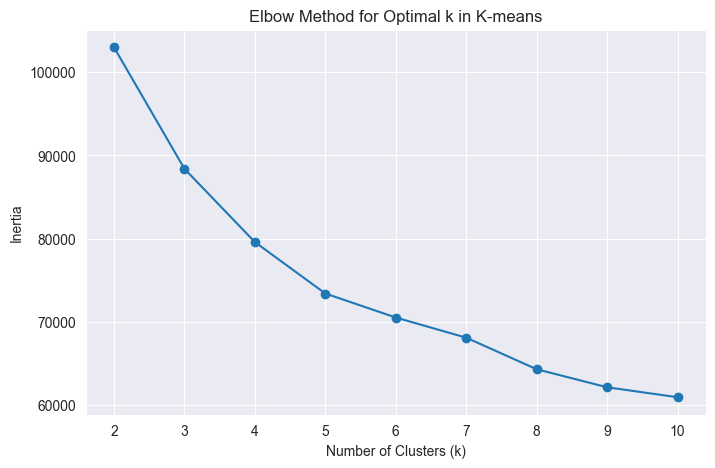

In [8]:
inertia = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled, sample_weight=weights)
    inertia.append(kmeans.inertia_)

# Affichage du graphique de la méthode du coude
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title("Elbow Method for Optimal k in K-means")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.xticks(k_range)
plt.show()

La méthode du coude ne donne ici pas de résultat clair concernant le nombre de clusters à définir.

On utilise ensuite la méthode du dendrogramme.

On définit pour ça la matrice de distances pondérée par les poids des individus.

In [9]:
weighted_distances = weighted_distance_matrix(features_scaled, weights)

# Conversion en format condensé pour linkage
condensed_weighted_distances = squareform(weighted_distances)

# Clustering hiérarchique avec la matrice de distances pondérées
Z = linkage(condensed_weighted_distances, method='ward')
Z

100%|██████████| 5000/5000 [01:18<00:00, 63.84it/s] 


array([[3.16000000e+02, 4.47700000e+03, 0.00000000e+00, 2.00000000e+00],
       [2.31100000e+03, 2.81800000e+03, 0.00000000e+00, 2.00000000e+00],
       [2.32500000e+03, 2.74100000e+03, 0.00000000e+00, 2.00000000e+00],
       ...,
       [9.99100000e+03, 9.99500000e+03, 1.28061460e+02, 3.59200000e+03],
       [9.99400000e+03, 9.99600000e+03, 1.69276046e+02, 4.78700000e+03],
       [9.99300000e+03, 9.99700000e+03, 2.11887485e+02, 5.00000000e+03]])

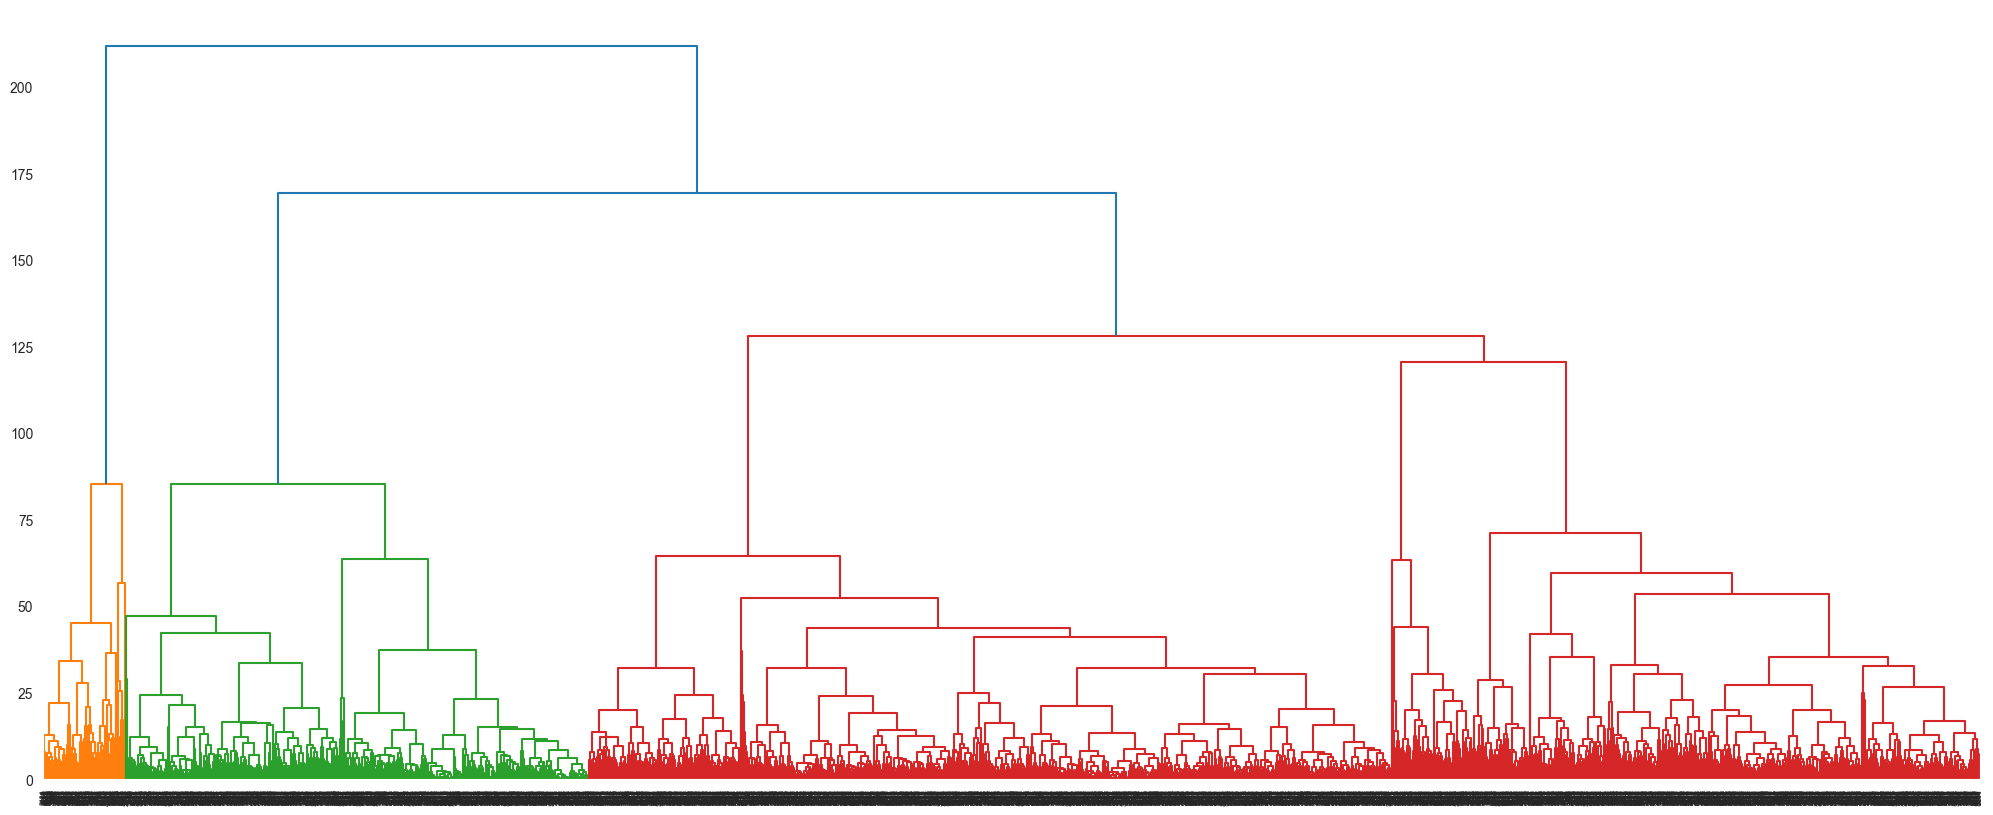

In [10]:
plt.figure(figsize=(25, 10))
dendrogram(Z, orientation='top')
plt.show()

Au vu de la figure présente, on choisit ici 5 clusters.

## K-means clustering

Il s'agit de la même méthode que précedemment; on prend en compte les distances pondérées pour le calcul des moyennes.

In [11]:
# On choisit 5 clusters
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(features_scaled, sample_weight=weights)

# Ajout des labels dans le dataframe
fic_epita_kantar_codes['cluster'] = kmeans.labels_
fic_epita_kantar_codes

,cle,Respondent_ID,weight,A11,A12,A13,A14,A4,A5,A5bis,...,C1_1_slice,C1_2_slice,C1_3_slice,C1_4_slice,C1_5_slice,C1_6_slice,C1_7_slice,C1_8_slice,C1_9_slice,cluster
0,1,MET20_999999996,2.501255,1,0,0,0,1,2.0,0.0,...,2,2,2,2,2,2,2,2,2,3
1,2,MET20_98888888,0.722914,1,0,0,0,1,5.0,0.0,...,4,4,4,4,4,4,4,4,4,1
2,3,MET20_1978307,1.039611,1,0,0,0,1,2.0,0.0,...,4,4,4,4,4,4,4,4,4,1
3,4,MET20_1302078,0.976590,1,1,1,0,1,1.0,0.0,...,4,4,5,5,5,5,5,4,4,4
4,5,MET20_1869308,0.812315,0,1,0,0,2,0.0,1.0,...,4,4,4,4,4,4,4,4,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4996,MET20_779605,0.905997,1,0,1,0,3,0.0,1.0,...,4,4,5,5,5,5,5,4,5,2
4996,4997,MET20_80000348,1.257884,0,1,0,0,2,0.0,1.0,...,4,5,5,5,5,5,5,5,5,2
4997,4998,MET20_288029,1.094695,0,1,0,0,2,0.0,2.0,...,5,5,5,5,5,5,5,5,5,2
4998,4999,MET20_1235808,2.022023,0,0,1,0,3,0.0,1.0,...,5,4,5,5,5,5,5,5,5,2


In [12]:
# Sauvegarde du df
fic_epita_kantar_codes.to_csv('../data/vert.csv', index=False)

## Informations générales sur les clusters

In [13]:
# On regarde la répartition des clusters
fic_epita_kantar_codes['cluster'].value_counts()

cluster
4    1890
1    1216
2    1203
0     366
3     325
Name: count, dtype: int64

In [14]:
# On regarde les moyennes des features par cluster
cluster_means = fic_epita_kantar_codes.groupby('cluster').mean(numeric_only=True)
cluster_means

,cle,weight,A11,A12,A13,A14,A4,A5,A5bis,A8_1_slice,...,B6,C1_1_slice,C1_2_slice,C1_3_slice,C1_4_slice,C1_5_slice,C1_6_slice,C1_7_slice,C1_8_slice,C1_9_slice
cluster,,,,,,,,,,,,,,,,,,,,,
0,2424.956284,0.976391,0.975410,0.112022,0.442623,0.0,1.046448,2.784153,0.060109,22.199454,...,3.000000,4.125683,4.122951,4.603825,4.713115,4.551913,4.830601,4.642077,4.308743,4.316940
1,2500.937500,0.969777,0.955592,0.120066,0.449013,0.0,1.152138,2.141447,0.180099,5.065789,...,2.952303,3.675987,3.654605,4.249178,4.395559,4.185033,4.564145,4.221217,3.909539,3.894737
2,2508.870324,0.974658,0.206983,0.600998,0.460515,0.0,2.442228,0.000000,1.788030,1.881962,...,3.425603,4.522028,4.458022,4.801330,4.847880,4.745636,4.874480,4.807149,4.658354,4.663342
3,2456.923077,1.025130,0.772308,0.283077,0.556923,0.0,1.523077,1.523077,0.723077,6.135385,...,2.190769,2.400000,2.393846,2.603077,2.550769,2.449231,2.633846,2.535385,2.455385,2.473846
4,2517.013228,0.952194,1.000000,0.065079,0.300529,0.0,1.000529,2.199471,0.000529,3.739683,...,3.610582,4.635979,4.530159,4.909524,4.941799,4.870370,4.959259,4.902646,4.735450,4.778836


In [15]:
# On regarde les variances intra-cluster
cluster_vars = fic_epita_kantar_codes.groupby('cluster').var(numeric_only=True)
cluster_vars

,cle,weight,A11,A12,A13,A14,A4,A5,A5bis,A8_1_slice,...,B6,C1_1_slice,C1_2_slice,C1_3_slice,C1_4_slice,C1_5_slice,C1_6_slice,C1_7_slice,C1_8_slice,C1_9_slice
cluster,,,,,,,,,,,,,,,,,,,,,
0,2.000758e+06,0.117689,0.024051,0.099745,0.247384,0.0,0.071809,2.005337,0.138843,101.710794,...,0.898630,0.641695,0.650595,0.371383,0.396923,0.702777,0.195883,0.394827,0.493458,0.595164
1,2.022900e+06,0.157646,0.042471,0.105737,0.247604,0.0,0.244325,1.882857,0.399637,17.692788,...,0.787847,0.428262,0.484720,0.416049,0.502663,0.710591,0.343207,0.445673,0.378641,0.469569
2,2.101563e+06,0.231742,0.164277,0.239999,0.248648,0.0,0.246868,0.000000,0.965847,4.882894,...,0.612389,0.377842,0.449775,0.189283,0.167356,0.302966,0.141470,0.184075,0.278356,0.296717
3,2.421609e+06,0.258975,0.176391,0.203571,0.247521,0.0,0.608262,2.176163,1.349003,50.259392,...,0.778310,0.709877,0.708604,0.869744,0.846952,0.896334,0.942678,0.780380,0.668528,0.682184
4,2.072303e+06,0.183080,0.000000,0.060876,0.210323,0.0,0.000529,1.436633,0.000529,12.106895,...,0.413652,0.278218,0.394273,0.092921,0.070724,0.166882,0.051807,0.097452,0.207372,0.200928


In [16]:
# On regarde les variances inter-cluster
inter_cluster_vars = cluster_means.var()
inter_cluster_vars

cle           1547.267283
weight           0.000739
A11              0.111451
A12              0.048366
A13              0.008403
A14              0.000000
A4               0.360498
A5               1.134162
A5bis            0.560353
A8_1_slice      67.275092
A8_2_slice      61.188291
A8_3_slice      46.883749
A8_4_slice       6.305885
B1_1_slice       0.341883
B1_2_slice       0.301738
B2_1_slice       0.345191
B2_2_slice       0.300345
B3               0.283764
B4               0.385931
B6               0.301163
C1_1_slice       0.818940
C1_2_slice       0.765934
C1_3_slice       0.893776
C1_4_slice       0.987791
C1_5_slice       0.982137
C1_6_slice       0.966443
C1_7_slice       0.956703
C1_8_slice       0.865687
C1_9_slice       0.871006
dtype: float64

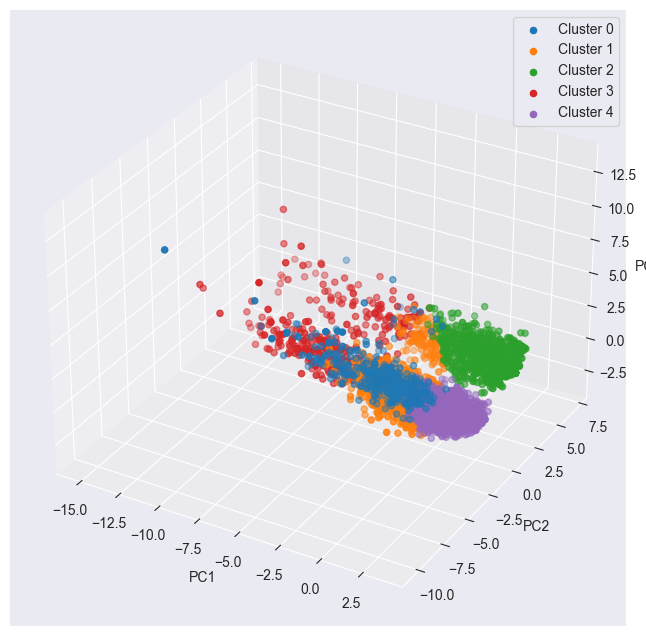

In [17]:
# Représentation en 3D dans l'espace des composantes principales
pca = PCA(n_components=3)
features_pca = pca.fit_transform(features_scaled)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for cluster in range(5):
    cluster_indices = fic_epita_kantar_codes[fic_epita_kantar_codes['cluster'] == cluster].index
    ax.scatter(features_pca[cluster_indices, 0], features_pca[cluster_indices, 1], features_pca[cluster_indices, 2], label=f'Cluster {cluster}')
    
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend()
plt.show()

On cherche ensuite à retrouver les composantes principales, pour l'explicabilité du graphe 3D précédent.

In [18]:
components = pd.DataFrame(pca.components_, columns=columns, index=['PC1', 'PC2', 'PC3'])

# Afficher les coefficients
display(components)

# Trouver les 3 features les plus importantes pour chaque composante
top_features_per_pc = components.apply(lambda row: row.abs().nlargest(3).index.tolist(), axis=1)

# Affichage des résultats
for pc, features in top_features_per_pc.items():
    print(f"{pc}: {', '.join(features)}")


,A11,A12,A13,A14,A4,A5,A5bis,A8_1_slice,A8_2_slice,A8_3_slice,...,B6,C1_1_slice,C1_2_slice,C1_3_slice,C1_4_slice,C1_5_slice,C1_6_slice,C1_7_slice,C1_8_slice,C1_9_slice
PC1,-0.079404,0.038503,-0.049795,-0.000000e+00,0.052532,-0.068064,0.036739,-0.101897,-0.109940,-0.094142,...,0.183877,0.279978,0.264648,0.283264,0.271812,0.256499,0.264813,0.284910,0.288260,0.285103
PC2,-0.334317,0.227057,0.051469,-1.110223e-16,0.360576,-0.344176,0.340320,-0.318749,-0.299544,-0.309375,...,-0.014533,-0.074502,-0.069751,-0.110194,-0.121646,-0.107099,-0.138126,-0.107919,-0.081275,-0.087860
PC3,-0.274346,0.206842,0.114947,2.220446e-16,0.302840,-0.192164,0.297645,0.360169,0.344422,0.379904,...,-0.102284,-0.028192,-0.008861,-0.003915,0.005214,-0.005001,0.024623,0.005069,-0.013567,-0.029020


PC1: C1_8_slice, C1_9_slice, C1_7_slice
PC2: A4, A5, A5bis
PC3: A8_3_slice, A8_4_slice, A8_1_slice


In [19]:
# Distribution des features principales par cluster
important_features = ['C1_8_slice', 'C1_9_slice', 'C1_7_slice']  # Exemple
cluster_analysis = fic_epita_kantar_codes.groupby('cluster')[important_features].mean(numeric_only=True)

display(cluster_analysis)

,C1_8_slice,C1_9_slice,C1_7_slice
cluster,,,
0,4.308743,4.316940,4.642077
1,3.909539,3.894737,4.221217
2,4.658354,4.663342,4.807149
3,2.455385,2.473846,2.535385
4,4.735450,4.778836,4.902646


In [20]:
# Distribution des features principales par cluster
important_features = ['A4', 'A5', 'A5bis']  # Exemple
cluster_analysis = fic_epita_kantar_codes.groupby('cluster')[important_features].mean(numeric_only=True)

display(cluster_analysis)

,A4,A5,A5bis
cluster,,,
0,1.046448,2.784153,0.060109
1,1.152138,2.141447,0.180099
2,2.442228,0.000000,1.788030
3,1.523077,1.523077,0.723077
4,1.000529,2.199471,0.000529


In [21]:
# Distribution des features principales par cluster
important_features = ['A8_3_slice', 'A8_4_slice', 'A8_1_slice']  # Exemple
cluster_analysis = fic_epita_kantar_codes.groupby('cluster')[important_features].mean(numeric_only=True)

display(cluster_analysis)

,A8_3_slice,A8_4_slice,A8_1_slice
cluster,,,
0,18.095628,6.557377,22.199454
1,3.431743,1.033717,5.065789
2,1.428096,0.615129,1.881962
3,4.418462,1.803077,6.135385
4,2.648677,0.708995,3.739683
